In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import EarlyStopping
import pickle as pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.activations import relu,sigmoid,elu
%matplotlib inline


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
pickle_in = open("./drive/MyDrive/Colab Notebooks/data/X_train.pickle","rb")
X_train = pickle.load(pickle_in)

pickle_in = open("./drive/MyDrive/Colab Notebooks/data/Y_train.pickle","rb")
Y_train = pickle.load(pickle_in)

pickle_in = open("./drive/MyDrive/Colab Notebooks/data/X_test.pickle","rb")
X_test = pickle.load(pickle_in)

pickle_in = open("./drive/MyDrive/Colab Notebooks/data/Y_test.pickle","rb")
Y_test = pickle.load(pickle_in)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")
print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")

X_train= (4608, 160, 160, 3) Y_train= (4608,)
X_test= (50, 160, 160, 3) Y_test= (50,)


In [5]:
mean_rgb = np.mean(X_train, axis=(0,1,2))
print(mean_rgb)

[36.40889 36.40889 36.40889]


In [6]:

X_train_norm = np.empty_like(X_train)
X_test_norm = np.empty_like(X_test)

In [7]:
for i in range(len(X_train)):
    for c in range(3):
        if(c==1):
            X_train_norm[i,:, :, c] = X_train[i,:, :, c] - mean_rgb[0]
        elif(c==2):
            X_train_norm[i,:, :, c] = X_train[i,:, :, c] - mean_rgb[1]
        else:
            X_train_norm[i,:, :, c] = X_train[i,:, :, c] - mean_rgb[2]
            
for i in range(len(X_test)):
    for c in range(3):
        if(c==1):
            X_test_norm[i,:, :, c] = X_test[i,:, :, c] - mean_rgb[0]
        elif(c==2):
            X_test_norm[i,:, :, c] = X_test[i,:, :, c] - mean_rgb[1]
        else:
            X_test_norm[i,:, :, c] = X_test[i,:, :, c] - mean_rgb[2]

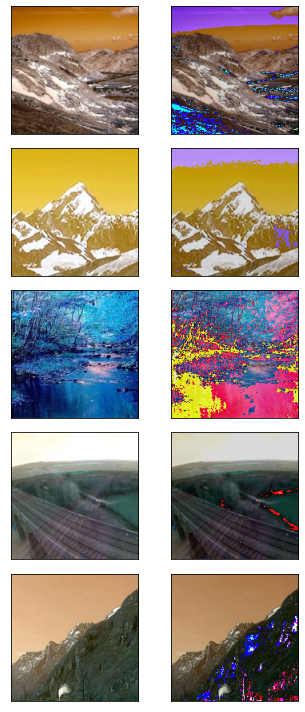

In [8]:
c = 0
plt.figure(figsize=(5,10))
for i in range(5):
    plt.subplot(5,2,c+1)
    plt.imshow(X_train[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(5,2,c+2)
    plt.imshow(X_train_norm[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])

    c += 2
    
plt.tight_layout()
plt.show()

In [9]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(160, 160, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1), 
    keras.layers.experimental.preprocessing.RandomZoom(0.5)],
)
# Create new model on top
inputs = keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)  # Apply random data augmentation
# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
base_model.trainable = True
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [10]:
model.get_config()

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


{'input_layers': [['input_2', 0, 0]],
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 160, 160, 3),
    'dtype': 'float32',
    'name': 'input_2',
    'ragged': False,
    'sparse': False},
   'inbound_nodes': [],
   'name': 'input_2'},
  {'class_name': 'Sequential',
   'config': {'layers': [{'class_name': 'InputLayer',
      'config': {'batch_input_shape': (None, 160, 160, 3),
       'dtype': 'float32',
       'name': 'random_flip_input',
       'ragged': False,
       'sparse': False}},
     {'class_name': 'RandomFlip',
      'config': {'dtype': 'float32',
       'mode': 'horizontal',
       'name': 'random_flip',
       'seed': None,
       'trainable': True}},
     {'class_name': 'RandomRotation',
      'config': {'dtype': 'float32',
       'factor': 0.1,
       'fill_mode': 'reflect',
       'fill_value': 0.0,
       'interpolation': 'bilinear',
       'name': 'random_rotation',
       'seed': None,
       'trainable': True}},
     {'class_name':

In [11]:
from tensorflow.keras.callbacks import LearningRateScheduler
def lr_schedule(epoch):
    lr = 1e-4
    if epoch > 20:
        lr *= 0.5e-5
    elif epoch > 15:
        lr *= 1e-4
    elif epoch > 10:
        lr *= 1e-3
    elif epoch > 5:
        lr *= 1e-2
    print('Learning rate: ', lr)
    return lr
lr_scheduler = LearningRateScheduler(lr_schedule)

h = model.fit(x=X_train_norm, y=Y_train, 
              epochs=30, 
              validation_split=0.2,
              batch_size=64,
              callbacks=lr_scheduler,
             )

Learning rate:  0.0001
Epoch 1/30
58/58 [==============================] - 105s 2s/step - loss: 0.1530 - binary_accuracy: 0.9346 - val_loss: 0.0614 - val_binary_accuracy: 0.9816 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 2/30
58/58 [==============================] - 84s 1s/step - loss: 0.0514 - binary_accuracy: 0.9832 - val_loss: 0.0495 - val_binary_accuracy: 0.9837 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 3/30
58/58 [==============================] - 84s 1s/step - loss: 0.0403 - binary_accuracy: 0.9859 - val_loss: 0.0452 - val_binary_accuracy: 0.9848 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 4/30
58/58 [==============================] - 84s 1s/step - loss: 0.0424 - binary_accuracy: 0.9845 - val_loss: 0.0461 - val_binary_accuracy: 0.9881 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 5/30
58/58 [==============================] - 84s 1s/step - loss: 0.0396 - binary_accuracy: 0.9878 - val_loss: 0.0588 - val_binary_accuracy: 0.9859 - lr: 1.0000e-04
Learning rate:  0.0001
Epoch 

In [17]:
model.save('./drive/MyDrive/Colab Notebooks/data/fire_noFire_Xception_Transfer_Learning.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
